In [4]:
import os
import re
import csv
import time
import requests
import numpy as np
import seaborn as sns

from bs4 import BeautifulSoup as bs

import warnings
warnings.filterwarnings('ignore')

# Crowling Data

In [5]:
def getUrl(url):
    headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'})
    r = requests.get(url, headers = headers)
    while r.status_code != 200:
      time.sleep(15)
      r = requests.get(url, headers = headers)
    soup = bs(r.text, 'html.parser') 
    return soup

*Scrap data*

In [6]:
base_url = 'https://www.edmunds.com'
if not os.path.isfile('data.csv'):
    csv_file = open('data.csv', 'w', newline='', encoding='utf-8')
    csv_writer = csv.DictWriter(csv_file, ['Exterior Color','Interior Color', 'Engine', 'Transmission', 'DriveTrain', 
                                           'City MPG','HWY MPG', 'Combine MPG', 'HorsePower' , 'Max Towing', 'Seats', 'Price'])
    csv_writer.writeheader()
    csv_file.close()
    
    with open('data.csv', "a", newline='') as fp:            
        wr_data = csv.writer(fp, dialect='excel') 
        
        for n in range(2, 6):
            price_range = '{}-{}'.format(n*10000, (n+1)*10000)
            price_url = 'https://www.edmunds.com/inventory/srp.html?price={}-{}&inventorytype=new&radius=500'.format(n*10000, (n+1)*10000)
            price_soup = getUrl(price_url)
            count_text = price_soup.find('span', class_='inventory-count').text.replace(',', '')
            count = int(re.findall(r'\d+', count_text)[0])
            print(count)
            pages = int(np.ceil(count / 21))
            for pageNumber in range(pages):
                print(n, ':', pageNumber)
                page_url = '{}&pagenumber={}'.format(price_url, pageNumber+1)
                page_soup = getUrl(price_url)
                
                links = page_soup.find_all('a', class_='usurp-inventory-card-vdp-link')
                prod_links = []
                for i in range(int(len(links)/2)):
                    prod_links.append(links[i*2+1]['href'])

                for link in prod_links:
                    # time.sleep(1)
                    prod_link = base_url + link
                    prod_soup = getUrl(prod_link)
                    try:                  
                      features = prod_soup.find('section', class_='vehicle-summary').find_all('li')
                      
                      ext_color = None
                      int_color = None
                      engine = None
                      transmission = None
                      drivetrain = None
                      mpg_city = None
                      mpg_hwy = None
                      mpg_combine = None
                      horsepower = None
                      maxtowing = None
                      seats = None
                      for soup in features:
                          key = soup.find('div', class_='pl-0 col-auto').text
                          try:
                              value = soup.find('div', class_='pr-0 font-weight-bold text-right ml-1 summary-value col').text
                          except:
                              value = soup.find('div', class_='pr-0 font-weight-bold text-right ml-1 col').text
                              
                          if key == 'Ext. Color':
                              ext_color = value.replace('Exterior color ', '')
                          elif key == 'Int. Color':
                              int_color = value.replace('Interior color ', '')
                          elif key == 'Engine':
                              engine = value
                          elif key == 'Transmission':
                              transmission = value
                          elif key == 'Drivetrain':
                              drivetrain = value
                          elif key == 'MPG':
                              mpgs = re.findall(r'\d+', value)
                              mpg_city = int(mpgs[0])
                              mpg_hwy = int(mpgs[1])
                              mpg_combine = int(mpgs[2])
                          elif key == 'Horsepower':
                              horsepower = int(re.findall(r'\d+', value)[0])
                          elif key == 'Max Towing Capacity':
                              maxtowing = int(re.findall(r'\d+', value.replace(',',''))[0])
                          elif key == 'Seats':
                              seats = int(re.findall(r'\d+', value)[0])
                          
                      record = [ext_color,int_color,engine,transmission,drivetrain,mpg_city,
                              mpg_hwy,mpg_combine,horsepower,maxtowing,seats,price_range]
                      # print(record)
                      wr_data.writerow(record)
                    except:
                      pass

# Data Analysis

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

*Load scraped data*

In [8]:
df = pd.read_csv('data.csv')
df

,Exterior Color,Interior Color,Engine,Transmission,DriveTrain,City MPG,HWY MPG,Combine MPG,HorsePower,Max Towing,Seats,Price
0,Crystal White Pearl,Gray premium cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
1,Pluton Blue w/Fusion Black Roof,Black leatherette/cloth,gas,automatic,all wheel drive,27.0,31.0,29.0,146,NaN,5,20000-30000
2,Clear White w/Fusion Black Roof,Black leatherette/cloth,gas,automatic,all wheel drive,27.0,31.0,29.0,146,NaN,5,20000-30000
3,Pure Red,Black premium cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
4,Crystal White Pearl,Black premium cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
...,...,...,...,...,...,...,...,...,...,...,...,...
17293,Machine Gray Metallic,Black leather,mild hybrid,automatic,all wheel drive,NaN,NaN,NaN,280,5000.0,7,50000-60000
17294,Artisan Red Premium,White Nappa premium leather,plug-in hybrid,automatic,all wheel drive,NaN,NaN,NaN,323,3500.0,7,50000-60000
17295,Sonic Silver,Black Nappa premium leather,plug-in hybrid,automatic,all wheel drive,NaN,NaN,NaN,323,3500.0,7,50000-60000
17296,Artisan Red Premium,Greige leather,plug-in hybrid,automatic,all wheel drive,NaN,NaN,NaN,323,3500.0,7,50000-60000


## EDA (Explanatory Data Analysis)

*Check missing values and remove them*

In [9]:
df_count = pd.DataFrame(df.isnull().sum(),columns=["Count"])
df_count[df_count['Count'] > 0].transpose()

,Interior Color,City MPG,HWY MPG,Combine MPG,Max Towing
Count,1537,7529,7529,7529,1218


In [10]:
df.dropna(inplace=True)
df.reset_index(drop = True, inplace=True)
df

,Exterior Color,Interior Color,Engine,Transmission,DriveTrain,City MPG,HWY MPG,Combine MPG,HorsePower,Max Towing,Seats,Price
0,Crystal White Pearl,Gray premium cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
1,Pure Red,Black premium cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
2,Crystal White Pearl,Black premium cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
3,Ice Silver Metallic,Gray cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
4,Crystal White Pearl,Gray premium cloth,gas,automatic,all wheel drive,37.0,34.0,29.0,152,1500.0,5,20000-30000
...,...,...,...,...,...,...,...,...,...,...,...,...
7679,Crystal White Pearl,Slate Black Nappa premium leather,gas,automatic,all wheel drive,22.0,29.0,25.0,260,3500.0,5,40000-50000
7680,Autumn Green Metallic,Gray StarTex leatherette,gas,automatic,all wheel drive,21.0,26.0,23.0,260,3500.0,5,40000-50000
7681,Crystal White Pearl,Slate Black leather,gas,automatic,all wheel drive,26.0,32.0,28.0,182,2700.0,5,40000-50000
7682,Magnetite Gray Metallic,Gray StarTex leatherette,gas,automatic,all wheel drive,21.0,26.0,23.0,260,3500.0,5,40000-50000


9614 rows removed, since they contain missing values.

*Count barplot of the exterior color*

Text(0.5, 1.0, 'Count of Exterior Color')

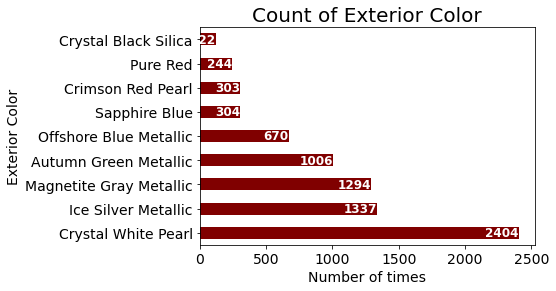

In [11]:
df_ext_color = df['Exterior Color'].value_counts()

# plot labels indicating the number times the team was runner-up
for i, value in enumerate(df_ext_color):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=12)

# plot the results using an horizontal bar plot
df_ext_color.plot(kind='barh', color='maroon')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Number of times', fontsize=14)
plt.ylabel('Exterior Color', fontsize=14)
plt.title('Count of Exterior Color', fontsize=20)

*Count barplot of interior color*

Text(0.5, 1.0, 'Count of Interior Color')

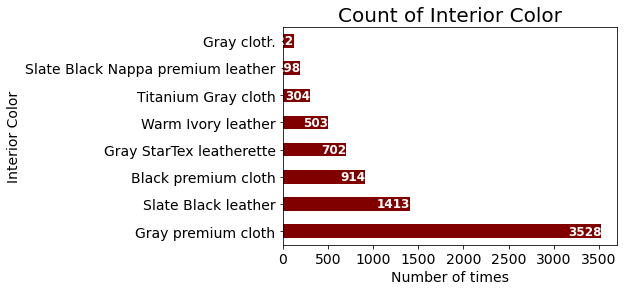

In [12]:
df_int_color = df['Interior Color'].value_counts()

# plot labels indicating the number times the team was runner-up
for i, value in enumerate(df_int_color):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=12)

# plot the results using an horizontal bar plot
df_int_color.plot(kind='barh', color='maroon')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Number of times', fontsize=14)
plt.ylabel('Interior Color', fontsize=14)
plt.title('Count of Interior Color', fontsize=20)

*Count barplot of price range*

Text(0.5, 1.0, 'Count of Price Range')

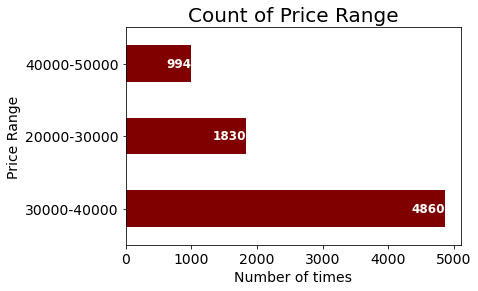

In [13]:
df_price = df['Price'].value_counts()

# plot labels indicating the number times the team was runner-up
for i, value in enumerate(df_price):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=12)

# plot the results using an horizontal bar plot
df_price.plot(kind='barh', color='maroon')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Number of times', fontsize=14)
plt.ylabel('Price Range', fontsize=14)
plt.title('Count of Price Range', fontsize=20)

From this graph, we can see that data imbalanced. Hence, we balanced data by select same number of rows for each price range.

In [14]:
df['Engine'].unique()

array(['gas'], dtype=object)

In [15]:
df['Transmission'].unique()

array(['automatic'], dtype=object)

In [16]:
df['DriveTrain'].unique()

array(['all wheel drive'], dtype=object)

In [17]:
df['Seats'].unique()

array([5], dtype=int64)

As we can see, Engin, Transmission, DriveTrain, Seats columns have unique value. So it will don't effect to the model and we will remove this columns with string columns.

In [18]:
df.drop(['Exterior Color', 'Interior Color','Engine', 'Transmission', 'DriveTrain', 'Seats'], axis=1, inplace=True)
df.reset_index(drop = True, inplace=True)
df

,City MPG,HWY MPG,Combine MPG,HorsePower,Max Towing,Price
0,37.0,34.0,29.0,152,1500.0,20000-30000
1,37.0,34.0,29.0,152,1500.0,20000-30000
2,37.0,34.0,29.0,152,1500.0,20000-30000
3,37.0,34.0,29.0,152,1500.0,20000-30000
4,37.0,34.0,29.0,152,1500.0,20000-30000
...,...,...,...,...,...,...
7679,22.0,29.0,25.0,260,3500.0,40000-50000
7680,21.0,26.0,23.0,260,3500.0,40000-50000
7681,26.0,32.0,28.0,182,2700.0,40000-50000
7682,21.0,26.0,23.0,260,3500.0,40000-50000


*Plot boxplot to find outliers*

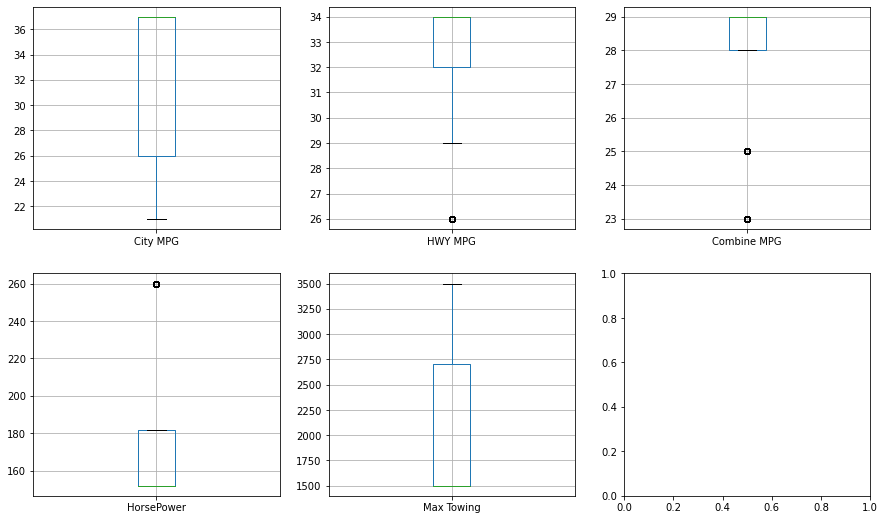

In [19]:
colnames = df.columns[:-1]
f, axes = plt.subplots(2, 3, figsize=(15, 9), sharey=False)
# Create a boxplot for each continue variable
for i in range(2):
    for j in range(3):
        if not (i==1 and j==2):
          col = colnames[i * 3 + j]
          df[[col]].boxplot(column=col, ax = axes[i, j])
plt.show()

*Remove outliers*

In [20]:
# Calculate the interquartile range
df_outliers = df.copy()
outliers_num = []
for col in colnames:
    series = df[col]
    Q1 = series.quantile(0.1)
    Q3 = series.quantile(0.9)
    iqr = Q3 - Q1
    lower = Q1 - 1.5 * iqr
    upper = Q3 + 1.5 * iqr
    
    outliers = df.loc[(series < lower) | (series > upper)]
    df_outliers = df_outliers.loc[(series >= lower) & (series <= upper)]
    outliers_num.append(len(outliers))
    

outliers_table = pd.DataFrame(list(zip(colnames, outliers_num)),
               columns =['Columns','Number of Outliers'])

outliers_table

,Columns,Number of Outliers
0,City MPG,0
1,HWY MPG,0
2,Combine MPG,0
3,HorsePower,0
4,Max Towing,0


This table shows that thereisn't outliers.

*Statistical Features*

In [21]:
df.describe()

,City MPG,HWY MPG,Combine MPG,HorsePower,Max Towing
count,7684.000000,7684.000000,7684.000000,7684.000000,7684.000000
mean,32.067933,32.722150,28.179984,172.251171,2070.015617
std,6.097205,2.045614,1.523732,32.697493,724.367313
min,21.000000,26.000000,23.000000,152.000000,1500.000000
25%,26.000000,32.000000,28.000000,152.000000,1500.000000
50%,37.000000,34.000000,29.000000,152.000000,1500.000000
75%,37.000000,34.000000,29.000000,182.000000,2700.000000
max,37.000000,34.000000,29.000000,260.000000,3500.000000


*Plot density graph of countinuous variables*

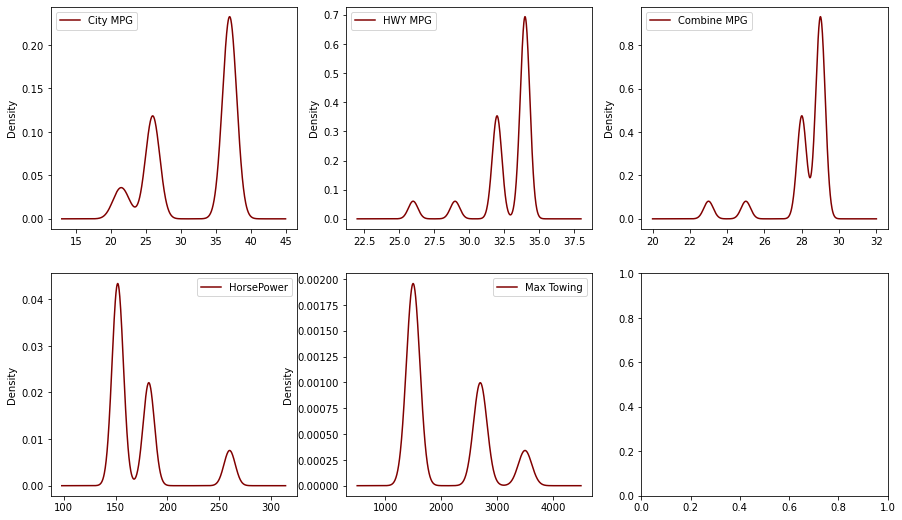

In [22]:
f, axes = plt.subplots(2, 3, figsize=(15, 9), sharey=False)
for i in range(2):
    for j in range(3):        
        if not (i == 1 and j == 2):
          col = colnames[i * 3 + j]
          df[[col]].plot.density(color = 'maroon', ax = axes[i, j])
plt.show()

## Classification Models

*Balanced Data*

In [23]:
df1 = df[df['Price'] == '20000-30000']
df2 = df[df['Price'] == '30000-40000']
df3 = df[df['Price'] == '40000-50000']

sampleNumber = len(df3)
df1 = df1.sample(sampleNumber, random_state = 1)
df2 = df2.sample(sampleNumber, random_state = 1)
df = pd.concat([df1, df2, df3])
df.reset_index(drop=True, inplace = True)
df

,City MPG,HWY MPG,Combine MPG,HorsePower,Max Towing,Price
0,37.0,34.0,29.0,152,1500.0,20000-30000
1,37.0,34.0,29.0,152,1500.0,20000-30000
2,37.0,34.0,29.0,152,1500.0,20000-30000
3,37.0,34.0,29.0,152,1500.0,20000-30000
4,37.0,34.0,29.0,152,1500.0,20000-30000
...,...,...,...,...,...,...
2977,22.0,29.0,25.0,260,3500.0,40000-50000
2978,21.0,26.0,23.0,260,3500.0,40000-50000
2979,26.0,32.0,28.0,182,2700.0,40000-50000
2980,21.0,26.0,23.0,260,3500.0,40000-50000


*Split data as train/test*

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
X = df.drop(['Price'], axis = 1)
y = df['Price'].values

# split ratio
train_ratio = 0.7
test_ratio = 0.3

# Split the data, Train/Test. train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=1)

*RandomForest Classifier*

Total Accuracy: 0.7505030181086519


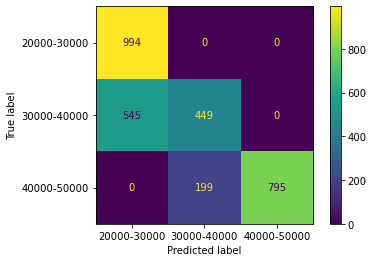

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train, y_train)
print('Total Accuracy:', clf_rf.score(X, y))

predictions = clf_rf.predict(X)
cm = confusion_matrix(y, predictions, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_rf.classes_)
disp.plot()
plt.show()


*RandomForest Classifier Cross-Validation*

[0.74539363 0.74204355 0.75503356 0.76006711 0.75      ]


Text(0.5, 1.0, 'Validation Accuracy of RandomForest')

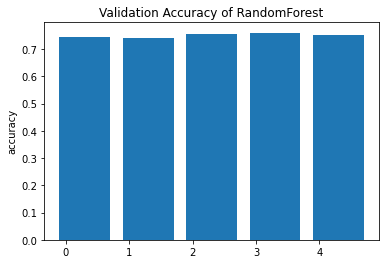

In [26]:
scores_rf = cross_val_score(estimator=clf_rf, X=X, y=y, cv = 5)
index = np.arange(5) + 0.3
print(scores_rf)
plt.bar(index, scores_rf)
plt.ylabel("accuracy")
plt.title('Validation Accuracy of RandomForest')

*Decision Tree Classifier*

Total Accuracy: 0.7505030181086519


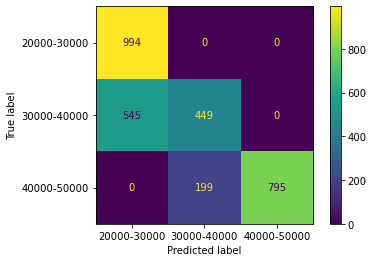

In [27]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)
print('Total Accuracy:', clf_dt.score(X, y))

predictions = clf_dt.predict(X)
cm = confusion_matrix(y, predictions, labels=clf_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_dt.classes_)
disp.plot()
plt.show()

*Decision Tree Classifier Cross-Validation*

[0.74539363 0.74204355 0.75503356 0.76006711 0.75      ]


Text(0.5, 1.0, 'Validation Accuracy of Decision Tree')

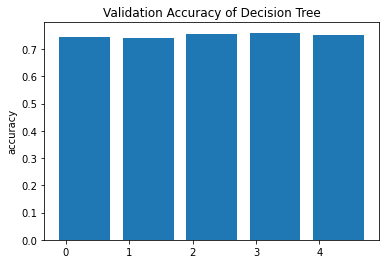

In [28]:
scores_dt = cross_val_score(estimator=clf_dt, X=X, y=y, cv = 5)
index = np.arange(5) + 0.3
print(scores_dt)
plt.bar(index, scores_dt)
plt.ylabel("accuracy")
plt.title('Validation Accuracy of Decision Tree')

*Support Vector Machine Classifier*

Test Accuracy: 0.7505030181086519


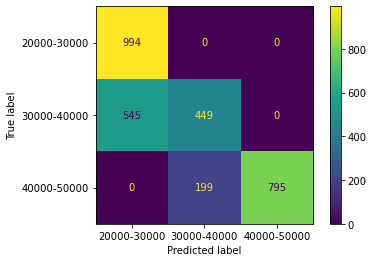

In [29]:
from sklearn.svm import SVC

clf_svm = SVC()
clf_svm.fit(X_train, y_train)
print('Test Accuracy:', clf_svm.score(X, y))

predictions = clf_svm.predict(X)
cm = confusion_matrix(y, predictions, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_svm.classes_)
disp.plot()
plt.show()

*SVM Cross-Validation*

[0.74539363 0.74204355 0.75503356 0.76006711 0.75      ]


Text(0.5, 1.0, 'Validation Accuracy of SVM')

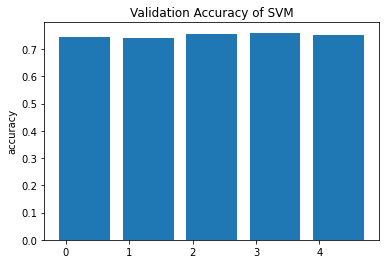

In [30]:
scores_svm = cross_val_score(estimator=clf_svm, X=X, y=y, cv = 5)
index = np.arange(5) + 0.3
print(scores_svm)
plt.bar(index, scores_svm)
plt.ylabel("accuracy")
plt.title('Validation Accuracy of SVM')

*Predict using RandomForst Classifier*

In [31]:
pred_range = clf_rf.predict(X)
df['Pred'] = pred_range
df

,City MPG,HWY MPG,Combine MPG,HorsePower,Max Towing,Price,Pred
0,37.0,34.0,29.0,152,1500.0,20000-30000,20000-30000
1,37.0,34.0,29.0,152,1500.0,20000-30000,20000-30000
2,37.0,34.0,29.0,152,1500.0,20000-30000,20000-30000
3,37.0,34.0,29.0,152,1500.0,20000-30000,20000-30000
4,37.0,34.0,29.0,152,1500.0,20000-30000,20000-30000
...,...,...,...,...,...,...,...
2977,22.0,29.0,25.0,260,3500.0,40000-50000,40000-50000
2978,21.0,26.0,23.0,260,3500.0,40000-50000,40000-50000
2979,26.0,32.0,28.0,182,2700.0,40000-50000,30000-40000
2980,21.0,26.0,23.0,260,3500.0,40000-50000,40000-50000


# Summary

In this project, we scraped the car price range with their features. Then predict the car price range using classification models such as RandomForest, Decision Tree, SVM. We got 75% accuracies for all models and predict the price ranges using RandomForest model. The car features are sam for most of cars and has different price range with same features. It is the main reason we got little low accuracy. If we use more other features, we can increase the classification accuracies.